In [80]:
import pandas as pd
import numpy as np

import scipy as sp
import sklearn as sk
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

import random
import time

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

In [81]:
#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#set visual parameters
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 14,7

In [82]:
#common model algorithms
#common model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes
from sklearn.svm import SVC as svc
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from xgboost import XGBClassifier
import tensorflow as tf
#from tensorflow import estimator
from sklearn.metrics import roc_curve, auc

#common model help tools
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [83]:
#import data
PATH1 = "C:/Users/kpunyakoti/Desktop/Data Science/Projects/AmEx Hack/Source/"   #where you read the files from
PATH2 = "C:/Users/kpunyakoti/Desktop/Data Science/Projects/AmEx Hack/Submissions/"   #where you export the files to

train = pd.read_csv(f'{PATH1}train.csv')
test = pd.read_csv(f'{PATH1}test.csv')
#Save the 'Id' column
train_ID = train['session_id']
test_ID = test['session_id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("session_id", axis = 1, inplace = True)
test.drop("session_id", axis = 1, inplace = True)

In [84]:
#concatenate train data and test data
ntrain = train.shape[0]
ntest = test.shape[0]

Target Variable
--

Treating outliers 
-- 
[always treat outliers first before treaing nulls]

CONCATENATE DATA

In [85]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.is_click.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['is_click'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (592149, 13)


In [86]:
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
all_data['Hour'] = all_data['DateTime'].dt.hour
all_data['Date'] = all_data['DateTime'].dt.day
all_data['Day'] = all_data['DateTime'].dt.weekday

Handling Missing Data
--

In [9]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
product_category_2,74.647597
city_development_index,26.975981
user_group_id,4.040706
user_depth,4.040706
gender,4.040706
age_level,4.040706


Text(0.5,1,'Percent missing data by feature')

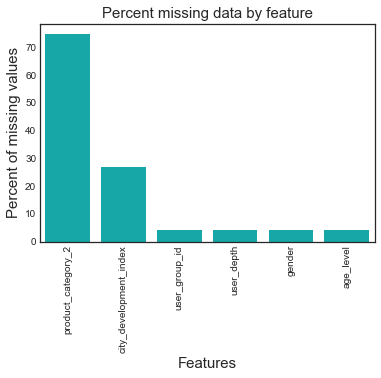

In [10]:
#plot missing data
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na, color="c")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [92]:
#for user_depth - fill mode which is 3
all_data['user_depth'].fillna(3, inplace = True)

#for gender fill mode -first fill female
#all_data.loc[((all_data.product == 'B')|(all_data.product == 'F') & all_data['gender'].isnull()==True), 'gender'] = 'Female'
#then rest nas with mode - male
all_data['gender'].fillna(all_data['gender'].mode()[0], inplace = True)
#for age_group_id
all_data['user_group_id'].fillna(all_data['user_group_id'].median(), inplace = True)
#for age_level
all_data['age_level'].fillna(3, inplace = True)


In [73]:
#for user_depth - fill mode Age values by sex and by title

all_data.loc[(all_data['Name'].str.contains('Miss|Ms') & all_data['Age'].isnull()==True), 'Age'] = 22
all_data.loc[(all_data['Name'].str.contains('Mr|Dr') & all_data['Age'].isnull()==True), 'Age'] = 29
all_data.loc[(all_data['Name'].str.contains('Mrs') & all_data['Age'].isnull()==True), 'Age'] = 35


#For Fare - Fill with median Fare by Pclass. Here pclass is 3 and median Fare for that Pclass is 8.05
all_data['Fare'].fillna(8.05, inplace = True) 

#for Embarked - two missing values fill with Mode
all_data['Embarked'].fillna(all_data['Embarked'].mode()[0], inplace = True)


In [18]:
#BsmtExposure-one row is marked NA(nobasement) where we have values for Basement:row-949-replace the value with mode which 'No'
#cond = ((str(all_data['BsmtQual'])!='None') & (str(all_data['BsmtExposure']) == 'None'))
#all_data.loc[cond,'BsmtExposure'] = 'No'

#BsmtFinType2-one row marked NA(nobasement) where we have values for Basement:row-333-replace the value with mode which is 'unf'
#cond2 = ((str(all_data['BsmtQual'])!='None') & (str(all_data['BsmtFinType2']) == 'None'))
#all_data.loc[cond2, 'BsmtFinType2'] = 'Unf'

In [19]:
#MSZoning - 4NAs -  impute using MSSubClass: where 20-MSz is RL, for 30-RM, 70-RM
#cond1 = ((all_data['MSZoning'].isnull()==True) & (str(all_data['MSSubClass']) == '20'))
#all_data.loc[cond1,'MSZoning'] = 'RL'
#cond2 = ((all_data['MSZoning'].isnull()==True) & (str(all_data['MSSubClass']) == '30'))
#all_data.loc[cond2,'MSZoning'] = 'RM'
#cond3 = ((all_data['MSZoning'].isnull()==True) & (str(all_data['MSSubClass']) == '70'))
#all_data.loc[cond3,'MSZoning'] = 'RM'

Drop Features
--

In [12]:
drop_cols = ['product_category_2', 'DateTime','city_development_index']   #
all_data.drop(drop_cols, axis=1, inplace=True)

In [13]:
#verify missing data
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
user_group_id,4.040706


Convert Datatypes
--

In [87]:
cat_cols = ['webpage_id','campaign_id', 'product_category_1', 'age_level', 'user_depth', 'user_group_id']
for x in cat_cols:
    all_data[x] = all_data[x].astype('str')
    

Feature Engineering
--

In [15]:
cols = ['webpage_id', 'campaign_id', 'product_category_1', 'age_level', 'user_depth' , 'gender', 
        'product', 'Hour', 'Day', 'Date']
# Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values)) 

In [88]:
all_data['user_group_id'].dtype

dtype('O')

In [19]:
#all_data = all_data.interpolate()
all_data = pd.get_dummies(all_data, columns=['webpage_id', 'campaign_id', 'product_category_1', 'age_level', 'user_depth' , 'gender', 
        'product', 'Hour', 'Date'])
print(all_data.shape)
all_data.head()

(592149, 82)


,user_group_id,user_id,var_1,Day,webpage_id_0,webpage_id_1,webpage_id_2,webpage_id_3,webpage_id_4,webpage_id_5,...,Hour_22,Hour_23,Date_0,Date_1,Date_2,Date_3,Date_4,Date_5,Date_6,Date_7
0,10.0,858557,0,6,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,8.0,243253,0,6,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,8.0,243253,0,6,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3.0,1097446,1,6,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2.0,663656,1,6,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [20]:
#retrieve cleaned data to separate train/test sets for Machine Learning
train = all_data[:ntrain]
test = all_data[ntrain:]
print(train.shape)
print(test.shape)

(463291, 82)
(128858, 82)


In [ ]:
train.to_csv(f'{PATH2}train_data_cleaned.csv', index=False)
test.to_csv(f'{PATH2}test_data_cleaned.csv', index=False)

In [21]:
#imp_feat = ['Hour','product','webpage_id','age_level','gender','campaign_id', 'user_depth','product_category_1',
 #          'user_group_id']
#drop_cols = ['user_id', 'var_1']   #
drop_cols = ['user_group_id', 'user_id', 'var_1']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

Machine Learning
--

Define a cross validation strategy

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [69]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(train,y_train, train_size = 0.6, test_size = 0.3, 
                                                                    shuffle = True, random_state = 0)

Initializing Models
--

c:\users\kpunyakoti\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


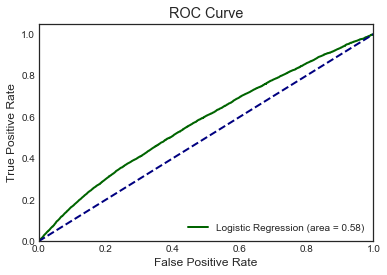

In [24]:
lr_model = linear_model.LogisticRegression(solver='sag', C=0.5)
lr_model.fit(train_x, train_y)

#y_predict = lr_model.predict(test_x)

lr_predict_probabilities = lr_model.predict_proba(test_x)[:,1]

lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_predict_probabilities)
lr_roc_auc = auc(lr_fpr, lr_tpr)

plt.figure()
#plt.plot(fpr, tpr, color='darkorange',
 #        lw=2, label='K-nearest Neighbours (area = %0.2f)' % roc_auc)
plt.plot(lr_fpr, lr_tpr, color='darkgreen',
         lw=2, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [70]:
testy['clicks'] = pd.DataFrame(train_y)
testy.clicks.value_counts()

0    86446
1     6213
Name: clicks, dtype: int64

In [73]:
sv = svc()
sv.fit(train_x, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [76]:
svc_predict_probabilities = svc.predict_proba(test_x)[:,1]

svc_fpr, svc_tpr, _ = roc_curve(test_y, svc_predict_probabilities)
svc_roc_auc = auc(svc_fpr, svc_tpr)

plt.figure()
#plt.plot(fpr, tpr, color='darkorange',
 #        lw=2, label='K-nearest Neighbours (area = %0.2f)' % roc_auc)
plt.plot(svc_fpr, svc_tpr, color='darkgreen',
         lw=2, label='svc (area = %0.2f)' % svc_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


TypeError: 'property' object is not callable

In [98]:
xgb = XGBClassifier()
xgb.fit(train_x, train_y)

xgb_predict_probabilities = xgb.predict_proba(test_x)[:,1]

xgb_fpr, xgb_tpr, _ = roc_curve(test_y, xgb_predict_probabilities)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)


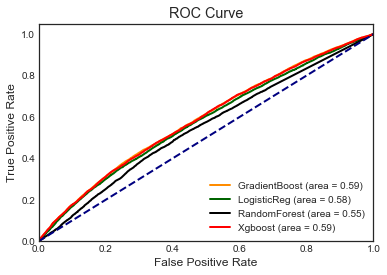

In [100]:
rf = ensemble.RandomForestClassifier()
rf.fit(train_x, train_y)

rf_predict_probabilities = rf.predict_proba(test_x)[:,1]

rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_predict_probabilities)
rf_roc_auc = auc(rf_fpr, rf_tpr)

plt.figure()
plt.plot(gb_fpr, gb_tpr, color='darkorange',
         lw=2, label='GradientBoost (area = %0.2f)' % gb_roc_auc)
plt.plot(lr_fpr, lr_tpr, color='darkgreen',
         lw=2, label='LogisticReg (area = %0.2f)' % lr_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='black',
         lw=2, label='RandomForest (area = %0.2f)' % rf_roc_auc)
plt.plot(xgb_fpr, xgb_tpr, color='red',
         lw=2, label='Xgboost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Final Training and Predictions
--

In [77]:
#submit = pd.DataFrame()
#submit['Id'] = test.index
#submit['SalePrice'] = ensemble
preds = sv.predict(test)
submit = pd.DataFrame({'session_id': test_ID, 'is_click': preds})
submit.to_csv(f'{PATH2}submission_lgb.csv', index=False)

In [79]:
prd['clck'] = pd.DataFrame(preds)
prd.clck.value_counts()

0    128858
Name: clck, dtype: int64

In [93]:
def OHEncode (df, cols):
    for x in cols:
        x_ohe = pd.get_dummies(df[x], prefix=x)
        df = pd.concat([df, x_ohe], axis=1)
        df = df.drop([x], axis=1)
    return df


In [159]:
testing=False
chunksize=50000
clf = linear_model.LogisticRegression()

In [160]:
train2 = pd.read_csv(f'{PATH1}train.csv')#, iterator=True,chunksize=chunksize) #Load data
test2 = pd.read_csv(f'{PATH1}test.csv')#, iterator=True,chunksize=chunksize) #Load data

In [161]:
train2['DateTime'] = pd.to_datetime(train2['DateTime'])
train2['Hour'] = train2['DateTime'].dt.hour
train2['Date'] = train2['DateTime'].dt.day
test2['DateTime'] = pd.to_datetime(test2['DateTime'])
test2['Hour'] = test2['DateTime'].dt.hour
test2['Date'] = test2['DateTime'].dt.day

In [162]:
train2['user_depth'].fillna(3, inplace = True)
train2['gender'].fillna(train2['gender'].mode()[0], inplace = True)
train2['user_group_id'].fillna(train2['user_group_id'].median(), inplace = True)
train2['age_level'].fillna(3, inplace = True)

test2['user_depth'].fillna(3, inplace = True)
test2['gender'].fillna(test2['gender'].mode()[0], inplace = True)
test2['user_group_id'].fillna(test2['user_group_id'].median(), inplace = True)
test2['age_level'].fillna(3, inplace = True)

In [163]:
cols = ['webpage_id', 'campaign_id', 'age_level', 'user_depth' , 'gender', 
        'product', 'Hour', 'Date']
# Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train2[c].values)) 
    train2[c] = lbl.transform(list(train2[c].values)) 
    lbl.fit(list(test2[c].values)) 
    test2[c] = lbl.transform(list(test2[c].values)) 


In [164]:
train2.to_csv(f'{PATH1}train2.csv', index=False)
test2.to_csv(f'{PATH1}test2.csv', index=False)

In [165]:
train3 = pd.read_csv(f'{PATH1}train2.csv', iterator=True,chunksize=chunksize) #Load data
test3 = pd.read_csv(f'{PATH1}test2.csv', iterator=True,chunksize=chunksize)

In [166]:
print('Chunks training')
for chunk in train3:
    chunk = chunk.drop(['var_1','product_category_2', 'DateTime','city_development_index'], axis=1)
    #chunk = OHEncode(chunk,cols) # Perform OHE
    predictors=[x for x in chunk.columns if x not in ['user_id','age_level','gender','product_category_1','is_click']] # Select columns for prediction
    chunk=chunk.fillna(0.0)
    clf.fit(chunk[predictors], chunk['is_click']) #Fit classifier
    if testing:
        break
train3='' #remove train

Chunks training


In [167]:
chunk.head()

,session_id,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,gender,age_level,user_depth,is_click,Hour,Date
450000,383661,468455,7,0,0,1,5.0,1,5,2,0,18,5
450001,170459,1098184,7,4,3,4,4.0,1,4,2,0,18,5
450002,129427,1043803,2,4,3,4,11.0,0,5,2,0,18,5
450003,351807,553276,7,6,6,1,5.0,1,5,2,0,18,5
450004,308722,370546,2,5,3,5,3.0,1,3,2,0,18,5


In [169]:
print('Testing')
predY=[]
for chunk in test3:
    init_chunk_size=len(chunk)
    chunk = chunk.drop(['var_1','product_category_2', 'DateTime','city_development_index'], axis=1)
    #chunk = OHEncode(chunk,cols)
    chunk=chunk.fillna(0.0)
    chunk_pred=list(clf.predict_proba(chunk[predictors]).astype(float)[:,1])
    predY += chunk_pred
    if testing:
        break
print('Done Testing')

Testing
Done Testing


In [ ]:
predY

In [173]:
print('Testing')
predY2=[]
for chunk in test3:
    init_chunk_size=len(chunk)
    chunk = chunk.drop(['var_1','product_category_2', 'DateTime','city_development_index'], axis=1)
    #chunk = OHEncode(chunk,cols)
    chunk=chunk.fillna(0.0)
    chunk_pred=list(clf.predict(chunk[predictors])[:,1])
    predY2 += chunk_pred
    if testing:
        break
print('Done Testing')

Testing
Done Testing


In [174]:
predY2

[]

In [176]:
print('Preparing for Submission')
test3='' #remove test
testnw= pd.read_csv(f'{PATH1}test_results.csv') #load full test

Preparing for Submission


In [177]:
results=pd.concat((testnw,pd.DataFrame(predY)) ,axis=1,ignore_index=True) #Combine the predicted values with the ids
print(results.head(10))

        0         1
0  411705  0.059081
1  208263  0.074284
2  239450  0.097067
3  547761  0.118446
4  574275  0.137288
5  394913  0.188910
6  562747  0.121449
7  224359  0.099884
8  395004  0.113816
9  572855  0.136442


In [178]:
results.columns = ['session_id','is_click']#Rename the columns
print(results.head(10))

   session_id  is_click
0      411705  0.059081
1      208263  0.074284
2      239450  0.097067
3      547761  0.118446
4      574275  0.137288
5      394913  0.188910
6      562747  0.121449
7      224359  0.099884
8      395004  0.113816
9      572855  0.136442


In [179]:
results.to_csv(f'{PATH1}result.csv', index=False)